## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №15

Решить задачу регрессии.  
Получить максимальную метрику качества (R2, RMSE).


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from datetime import datetime 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score


DATA_CSV_PATH = 'Walmart.csv'

- Store - Номер магазина (the store number)
- Date - Дата пятницы, окончание недели распродаж (the week of sales)
- Weekly_Sales - Сумма продаж для данного магазина (sales for the given store)
- Holiday_Flag - Признак праздничной недели (whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week)
- Temperature - Температура в день распродаж (Temperature on the day of sale)
- Fuel_Price - Стоимость топлива в регионе (Cost of fuel in the region)
- CPI – Преобладающий индекс потредительских цен (Prevailing consumer price index)
- Unemployment - Преобладающий уровень безработицы (Prevailing unemployment rate)

### Загрузка, анализ и преобразование данных

Предварительная загрузка и отображение части данных

In [ ]:
df_sample = pd.read_csv(DATA_CSV_PATH, sep=',', nrows=3)
df_sample.head()

Store - категориальный признак, значения не связаны - разбить на отдельные столбцы  
Date - разбить на стобцы Год/Месяц/Неделя
Holiday

Загрузить данные: для признаков явно указываем требуемые типы

In [80]:
dtypes={
    'Store': 'uint8',
    'Date': 'object',
    'Weekly_Sales': float,
    'Holiday_Flag': 'uint8',
    'Temperature': float,
    'Fuel_Price': float,
    'CPI': float,
    'Unemployment': float
    }

df_raw = pd.read_csv(DATA_CSV_PATH , dtype = dtypes, sep=',')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   uint8  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   uint8  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), object(1), uint8(2)
memory usage: 314.3+ KB


Преобразовать дату в отдельные значения номера года, квартала, месяца и недели

In [81]:
date = pd.to_datetime(df_raw['Date'], dayfirst=True)

df_raw.insert(2, 'Date_year', date.dt.year.astype('uint8'))
df_raw.insert(3, 'Date_quart', date.dt.quarter.astype('uint8'))
df_raw.insert(4, 'Date_month', date.dt.month.astype('uint8'))
df_raw.insert(5, 'Date_week', date.dt.isocalendar().week.astype('uint8'))

df_raw.drop(['Date'], inplace=True, axis=1)
#df_raw.info()

Проверить выборку на наличие строк-дубликатов

In [82]:
df_duplicateRows = df_raw[df_raw.duplicated()]
df_duplicateRows.shape

#df_raw = df_raw.drop_duplicates(keep='first')
#df_raw.shape

(0, 11)

In [ ]:
plt.figure(figsize=(12, 3))

df_raw.boxplot(column=['Weekly_Sales'], vert=0 ) #, notch=True, patch_artist=True)

#### Проверка исходных данных на нормальность

Построим распределение исходных данных с помощью гистограмм

array([[<AxesSubplot:title={'center':'CPI'}>]], dtype=object)

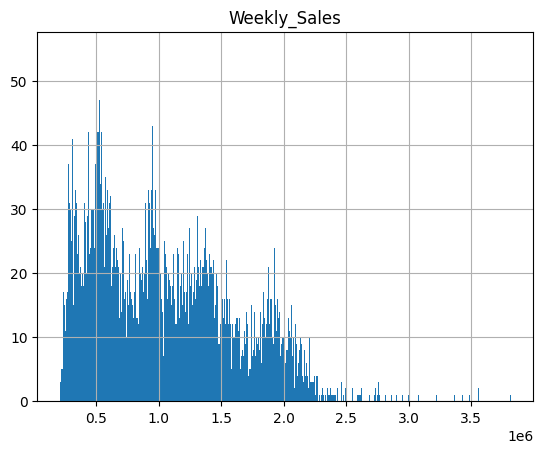

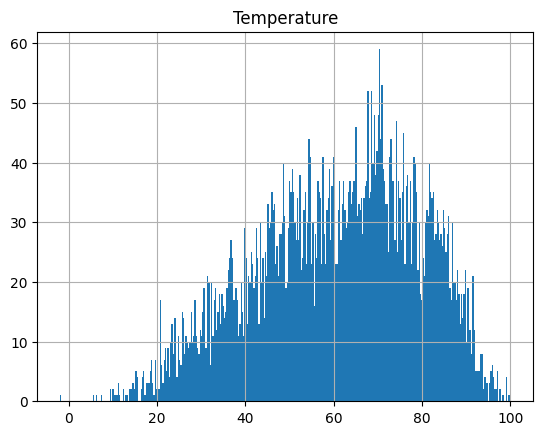

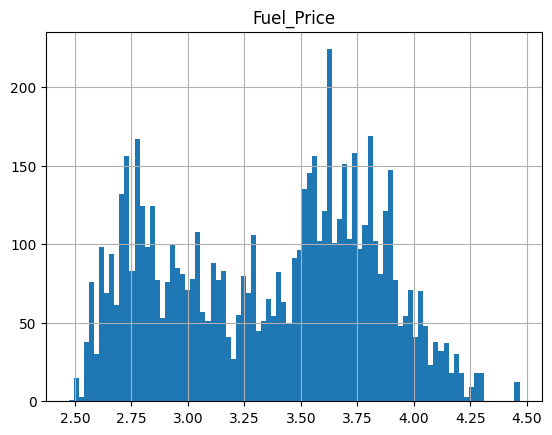

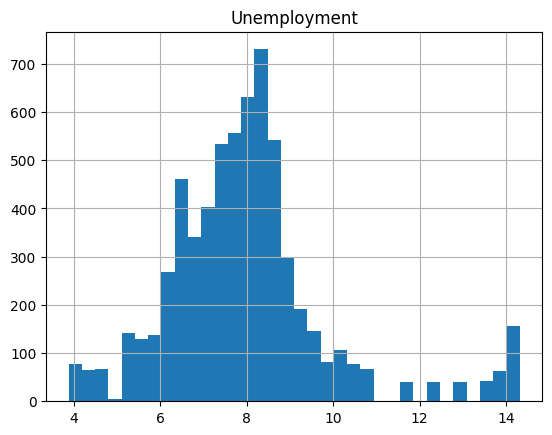

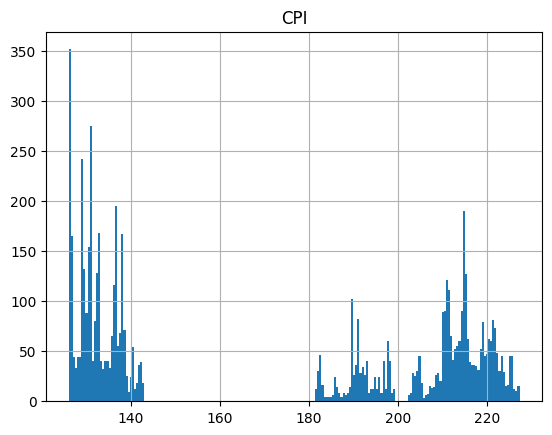

In [74]:
weekly_sales_bins = df_raw['Weekly_Sales'].value_counts().count()//10
temperature_bins = df_raw['Temperature'].value_counts().count()//10
fuel_price_bins = df_raw['Fuel_Price'].value_counts().count()//10
unemployment_bins = df_raw['Unemployment'].value_counts().count()//10
cpi_bins = df_raw['CPI'].value_counts().count()//10

df_raw.hist(column = ['Weekly_Sales'], bins= weekly_sales_bins)
df_raw.hist(column = ['Temperature'], bins= temperature_bins)
df_raw.hist(column = ['Fuel_Price'], bins= fuel_price_bins)
df_raw.hist(column = ['Unemployment'], bins= unemployment_bins)
df_raw.hist(column = ['CPI'], bins= cpi_bins)

#### Построение матрицы корреляции признаков

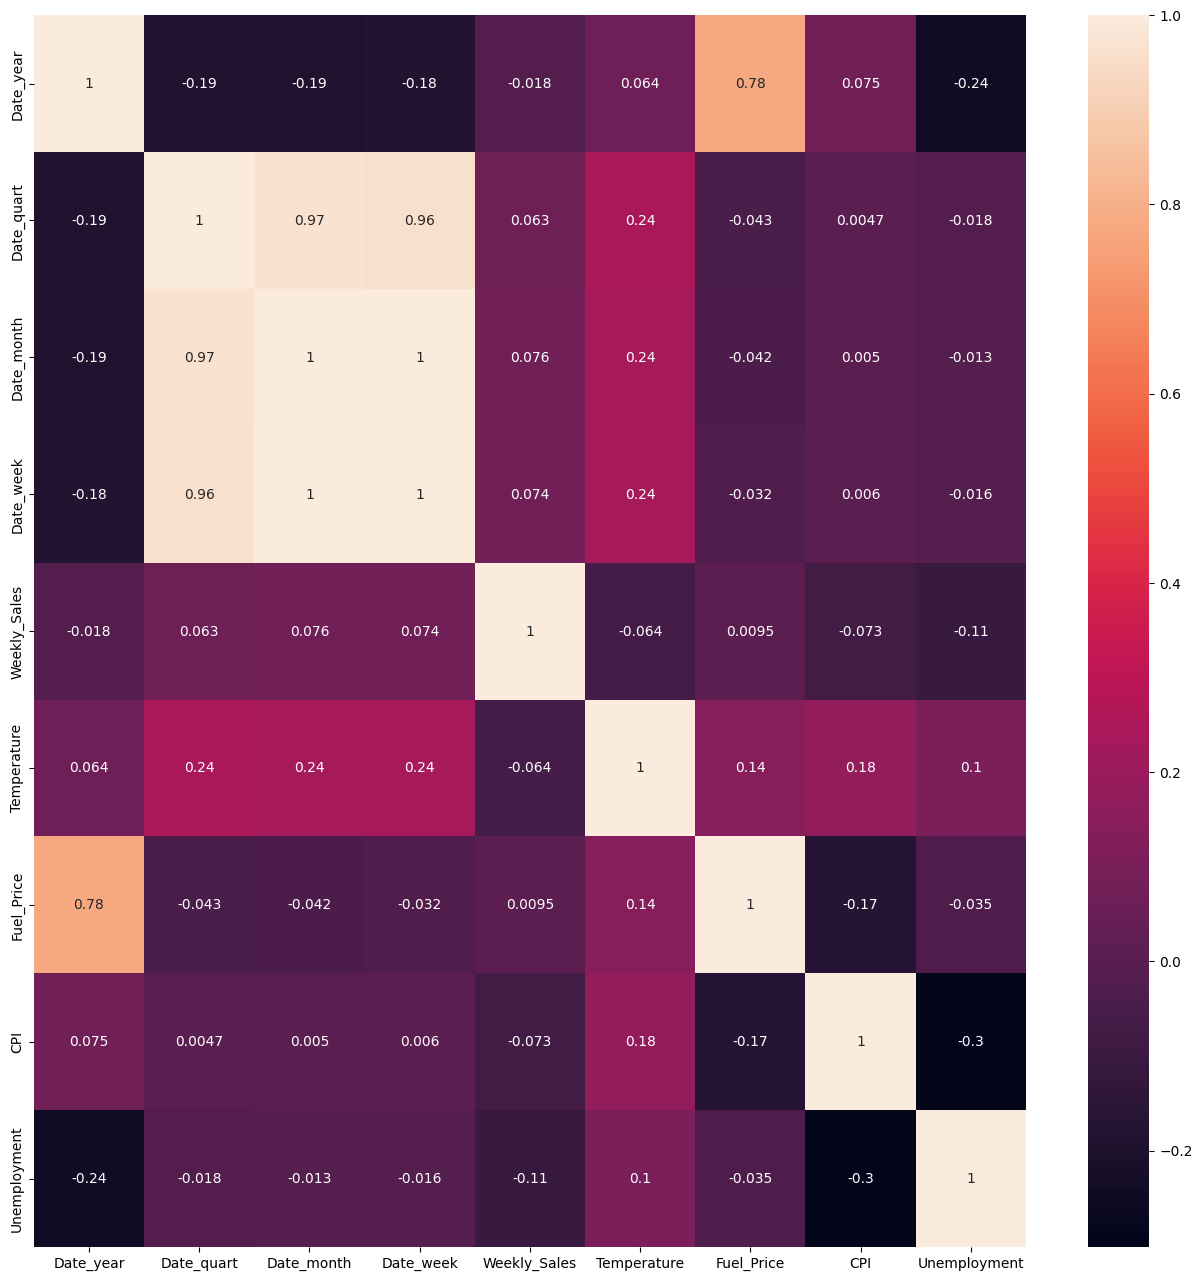

In [75]:
plt.figure(figsize=(16,16))
sn.heatmap(df_raw.corr(), annot=True, linewidths=0)
plt.show()

Выполнить разбиение исходной выборки данных на 2 подмножества (обучение и тестирование)

In [83]:
y = df_raw['Weekly_Sales']
X = df_raw.drop(['Weekly_Sales'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   uint8  
 1   Date_year     6435 non-null   uint8  
 2   Date_quart    6435 non-null   uint8  
 3   Date_month    6435 non-null   uint8  
 4   Date_week     6435 non-null   uint8  
 5   Holiday_Flag  6435 non-null   uint8  
 6   Temperature   6435 non-null   float64
 7   Fuel_Price    6435 non-null   float64
 8   CPI           6435 non-null   float64
 9   Unemployment  6435 non-null   float64
dtypes: float64(4), uint8(6)
memory usage: 238.9 KB


### Выполнить обучение и проверку модели RandomForest

In [89]:
model = LinearRegression()
model.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, model.predict(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, model.predict(X_test)[:, 1])))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Выполнить подбор следующих гиперпараметров модели RandomForest:

n_estimators — число «деревьев» в «случайном лесу».  
max_features — число признаков для выбора расщепления.  
max_depth — максимальная глубина деревьев.  
min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.  
min_samples_leaf — минимальное число объектов в листьях.  
bootstrap — использование для построения деревьев подвыборки с возвращением.  

In [ ]:
params = { 'n_estimators': range (100, 800, 100),
            'max_features': ['log2', 'sqrt'],
            'max_depth': range (10, 18, 2),
            'min_samples_leaf': range (2,9,2),
            'min_samples_split': range (2,9,2),
            'bootstrap': [True, False]}

forest_grid = GridSearchCV(forest, param_grid=params, n_jobs=-1, cv=5, verbose=5)
forest_grid.fit(X_train,y_train)

print('Best Parameters : {}'.format(forest_grid.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(forest_grid.best_score_))

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest_grid.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest_grid.predict(X_test))))

Выводы: на данном наборе данных, подбор гиперпараметров не обеспечивает существенного прироста

Выполнить оценку важности признаков

In [ ]:
feature_names = X_train.columns
# cоздаем объект со значениями важностей, вычисленными моделью forest
importances = forest.feature_importances_
# задаем сортировку значений важности и сопоставляем названия предикторов важностям
indices = np.argsort(importances)[::-1]

#print("Важность предикторов:")
#for f, idx in enumerate(indices):
#    print("{:2d}. '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

График важности для первых 20 признаков:

In [ ]:
d_first = 20
plt.figure(figsize=(12, 5))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

### Выполнить обучение и проверку моделей реализующих алгоритмы Наивного Байеса

GaussianNB (Гаусовский наивный байес) реализует гауссовский наивный байесовский алгоритм для классификации

In [79]:
gaus_nb = GaussianNB()

gaus_nb.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, gaus_nb.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, gaus_nb.predict(X_test))))

ValueError: Unknown label type: (array([ 209986.25,  215359.21,  219804.85, ..., 3595903.2 , 3676388.98,
       3749057.69]),)

MultinomialNB (Мультиномиальный наивный байес) реализует наивный байесовский алгоритм для полиномиально распределенных данных

In [ ]:
mult_nb = MultinomialNB()

mult_nb.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, mult_nb.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, mult_nb.predict(X_test))))

ComplementNB (Дополнение наивного байеса) реализует наивный байесовский алгоритм дополнения (CNB).  
CNB — это адаптация стандартного полиномиального наивного байесовского алгоритма (MNB), который особенно подходит для несбалансированных наборов данных.

In [ ]:
cpl_nb = ComplementNB()

cpl_nb.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, cpl_nb.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, cpl_nb.predict(X_test))))

CategoricalNB (Категориальный Наивный Байес) реализует категориальный наивный алгоритм Байеса для категориально распределенных данных.  
Предполагается, что матрица выборки  кодируется таким образом, что все категории для каждой функции i представлены числами 0,...,Ni-1 где Ni - количество доступных категорий функций i.

In [ ]:
cat_nb = CategoricalNB()

cat_nb.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, cat_nb.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, cat_nb.predict(X_test))))

Выполнить подбор гиперпараметров модели CategoricalNB

In [ ]:
n_classes = np.unique(y_train)

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False],
          'min_categories': [1, 4, 12, 18, 25, 30],
          'class_prior': [None, [0.1,]* len(n_classes),]
         }

cat_nb_grid = GridSearchCV(CategoricalNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
cat_nb_grid.fit(X_train,y_train)

print('Best Parameters : {}'.format(cat_nb_grid.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(cat_nb_grid.best_score_))

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, cat_nb_grid.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, cat_nb_grid.predict(X_test))))

Выводы:
даже без соответсвующей подготовки данных алгоритм CategoricalNB  показал лучший результат среди всех Байесовских алгоритмов,  
Использование подбора гиперпараметров улучшает алгоритм не существенно по отношению к базовому варианту 

### Выполнить обучение и проверку модели LinearRegression

In [ ]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, lr.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, lr.predict(X_test))))

print("Model intercept:", lr.intercept_)
print("Model coefs:    ", lr.coef_)

Добавим к модели линейной регрессии полиномиальные базисные функции

In [ ]:
lrp = make_pipeline(PolynomialFeatures(),
                           LinearRegression())

#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, train_size=0.5, random_state=42)

lrp.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, lrp.predict(X_train))))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, lrp.predict(X_test))))

Вывод:
Без подготовки параметров алгоритм Линейной регресии показывает результат сравнимый с алгоритмом RandomForest,  
при этом использование полиномиальных базисных функций заментно улучшает точность модели 